# Machine Learning Foundation

## Course 3, Part e: Bagging and Random Forest Lab

## Introduction

We will be using the customer churn data from the telecom industry that we used in the KNN Lab. Since we preprocessed the data there, we will import the preprocessed data, which is in a file called: 'churndata_processed.csv' 

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, sys, seaborn as sns
os.chdir('data')

## Part 1: Setup

* The raw churndata has been setup as a variable 'churndata', and we have imported it above.
* We will rely on the data preprocessing from the KNN lab, which is captured in the file 'churndata_processed.csv'
* First, import that file and examine its contents.
* Output summary statistics and check variable data types
* Using Seaborn, plot a heatmap of variable correlations


In [2]:
filepath = 'churndata_processed.csv'
data = pd.read_csv(filepath)

In [3]:
round(data.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
months,7043.0,0.43,0.40,0.0,0.00,0.25,0.75,1.0
multiple,7043.0,0.42,0.49,0.0,0.00,0.00,1.00,1.0
gb_mon,7043.0,0.24,0.24,0.0,0.04,0.20,0.32,1.0
security,7043.0,0.29,0.45,0.0,0.00,0.00,1.00,1.0
backup,7043.0,0.34,0.48,0.0,0.00,0.00,1.00,1.0
protection,7043.0,0.34,0.48,0.0,0.00,0.00,1.00,1.0
support,7043.0,0.29,0.45,0.0,0.00,0.00,1.00,1.0
unlimited,7043.0,0.67,0.47,0.0,0.00,1.00,1.00,1.0
contract,7043.0,0.38,0.42,0.0,0.00,0.00,1.00,1.0
paperless,7043.0,0.59,0.49,0.0,0.00,1.00,1.00,1.0


In [4]:
data.dtypes

months                       float64
multiple                       int64
gb_mon                       float64
security                       int64
backup                         int64
protection                     int64
support                        int64
unlimited                      int64
contract                     float64
paperless                      int64
monthly                      float64
satisfaction                 float64
churn_value                    int64
payment_Credit Card            int64
payment_Mailed Check           int64
internet_type_DSL              int64
internet_type_Fiber Optic      int64
internet_type_None             int64
offer_Offer A                  int64
offer_Offer B                  int64
offer_Offer C                  int64
offer_Offer D                  int64
offer_Offer E                  int64
dtype: object

<AxesSubplot:>

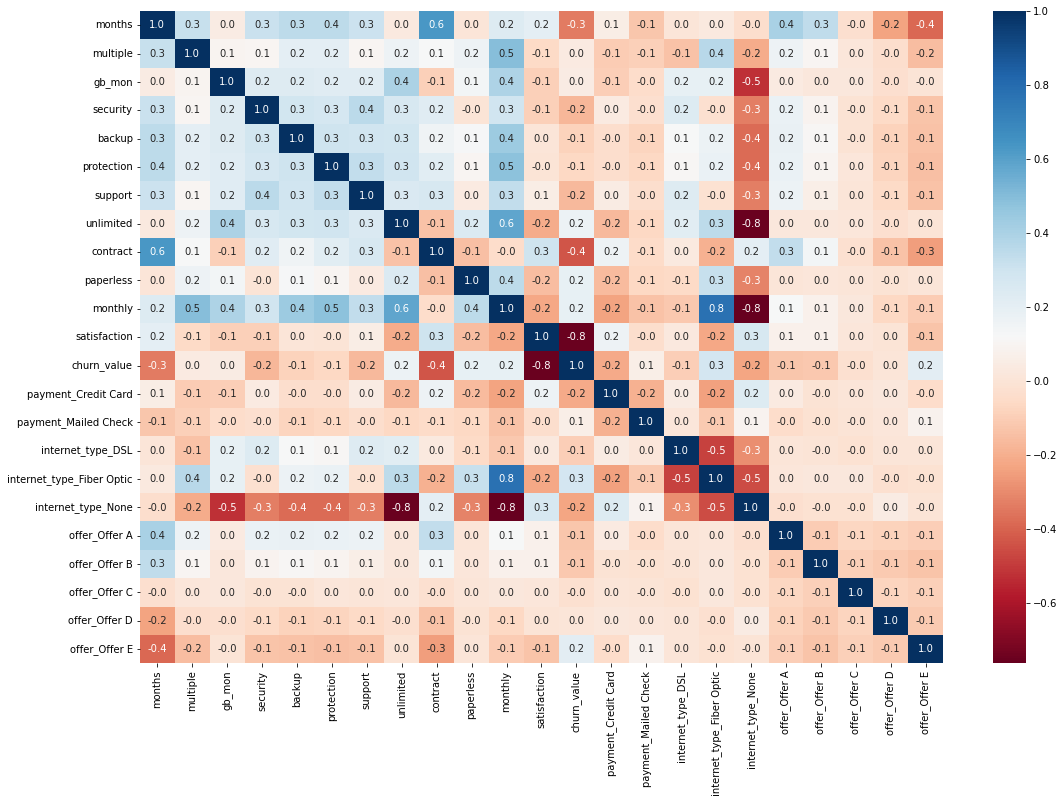

In [5]:
fig, ax = plt.subplots(figsize=(18,12)) 
sns.heatmap(data.corr(), annot=True, fmt='.1f', cmap='RdBu')

## Part 2: Examining the Target and Preprocessing

In this exercise, we will proceed as follows:
* Examine distribution of the predicted variable (`churn_value`).
* Split the data into train and test sets. Decide if a stratified split should be used or not based on the distribution.
* Examine the distribution of the predictor variable in the train and test data.

In [6]:
# Data are skewed at ~85% towards non-churned customers
# This will be important to remember when model building
target = 'churn_value'
data[target].value_counts()

0    5174
1    1869
Name: churn_value, dtype: int64

In [7]:
data[target].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: churn_value, dtype: float64

Given the skew in the predictor variable, let's split the data with the *churned* values being stratified.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

feature_cols = [x for x in data.columns if x != target]

# Split the data into two parts with 1500 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1500, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data[target]))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, target]

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, target]

In [9]:
y_train.value_counts(normalize=True)

0    0.73462
1    0.26538
Name: churn_value, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

0    0.734667
1    0.265333
Name: churn_value, dtype: float64

## Part 3: Random Forest and Out-of-bag Error

In this exercise, we will:
* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
* Plot the resulting oob errors as a function of the number of trees.

*Note:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.

In [11]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
15.0,0.055566
20.0,0.052138
30.0,0.049973
40.0,0.048890
50.0,0.049071
100.0,0.047447
150.0,0.046726
200.0,0.047447
300.0,0.047988


The error looks like it has stabilized around 100-150 trees.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

[Text(0, 0.5, 'out-of-bag error')]

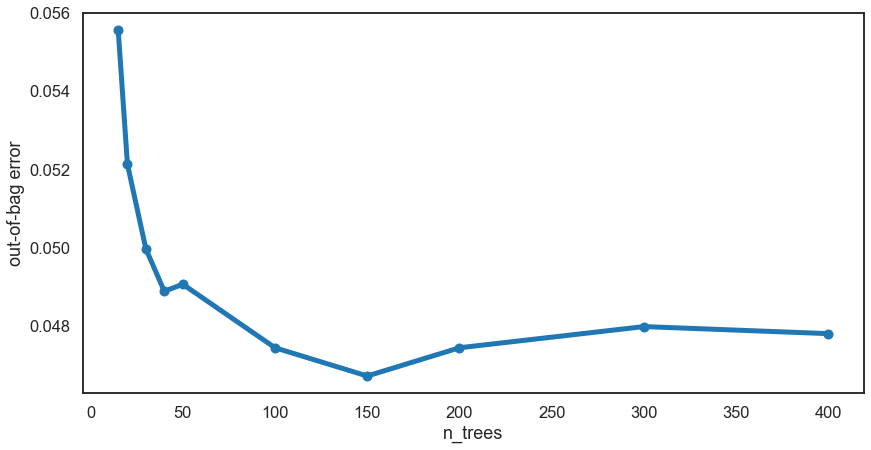

In [14]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error')

## Part 4: Extra Trees

Our exercise:
* Repeat question 3 using extra randomized trees (`ExtraTreesClassifier`). Note that the `bootstrap` parameter will have to be set to `True` for this model.
* Compare the out-of-bag errors for the two different types of models.

In [15]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

,oob
n_trees,
15.0,0.066570
20.0,0.063864
30.0,0.057550
40.0,0.053942
50.0,0.052318
100.0,0.051236
150.0,0.048890
200.0,0.048530
300.0,0.049612


Combine the two dataframes into a single one for easier plotting.

In [16]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

oob_df

,RandomForest,ExtraTrees
n_trees,,
15.0,0.055566,0.066570
20.0,0.052138,0.063864
30.0,0.049973,0.057550
40.0,0.048890,0.053942
50.0,0.049071,0.052318
100.0,0.047447,0.051236
150.0,0.046726,0.048890
200.0,0.047447,0.048530
300.0,0.047988,0.049612


The random forest model performs consistently better than the extra randomized trees.

[Text(0, 0.5, 'out-of-bag error')]

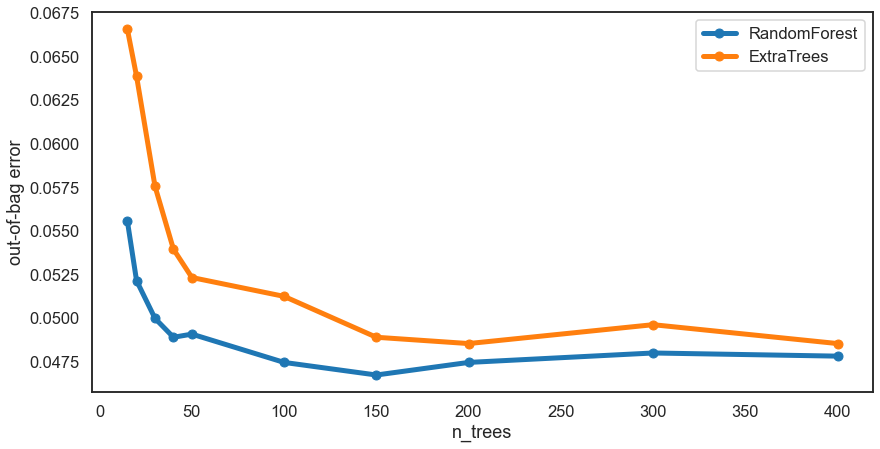

In [17]:
sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot(marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error')

## Part 5: Gathering Results

Here, we will:
* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?  
Accuracy can be misleading when the distribution of the target variable is imbalanced. The F1 score provides a better measure of how well the model can predict the individual classes.

In [18]:
# Random forest with 100 estimators
model = RF.set_params(n_estimators=100)

y_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1102
           1       0.94      0.83      0.88       398

    accuracy                           0.94      1500
   macro avg       0.94      0.90      0.92      1500
weighted avg       0.94      0.94      0.94      1500

   accuracy  precision    recall    f1       auc
0      0.94     0.9375  0.829146  0.88  0.904591


## Part 6: Examining Results

The following exercises will help us examine results:
* Print or visualize the confusion matrix.
* Plot the ROC-AUC and precision-recall curves.
* Plot the feature importances.

Text(0.5, 76.5, 'Churn Prediction')

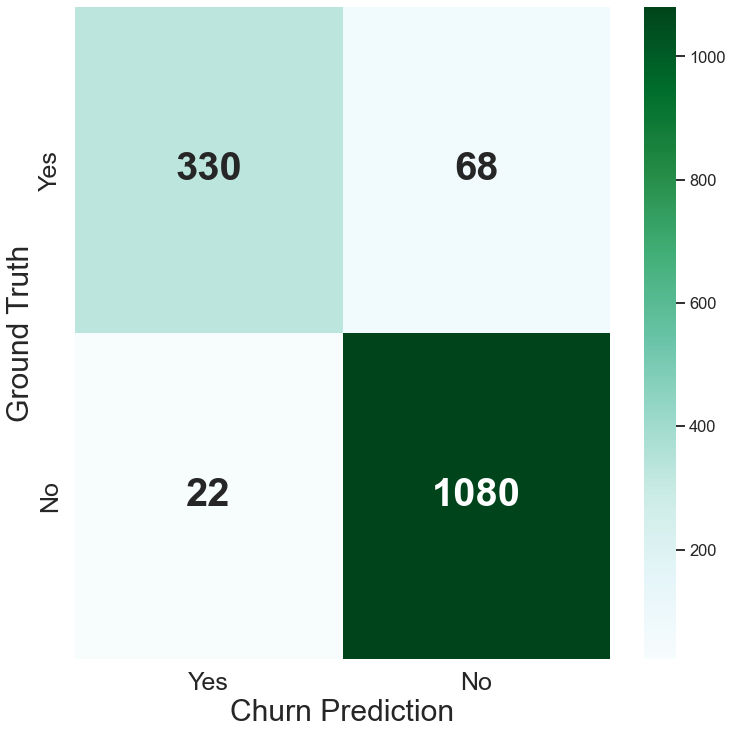

In [20]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', annot_kws={"size": 40, "weight": "bold"})

labels = ['Yes', 'No']
ax.set_xticklabels(labels, fontsize=25)
ax.set_yticklabels(labels, fontsize=25)
ax.set_ylabel('Ground Truth', fontsize=30)
ax.set_xlabel('Churn Prediction', fontsize=30)

The ROC-AUC and precision-recall curves.

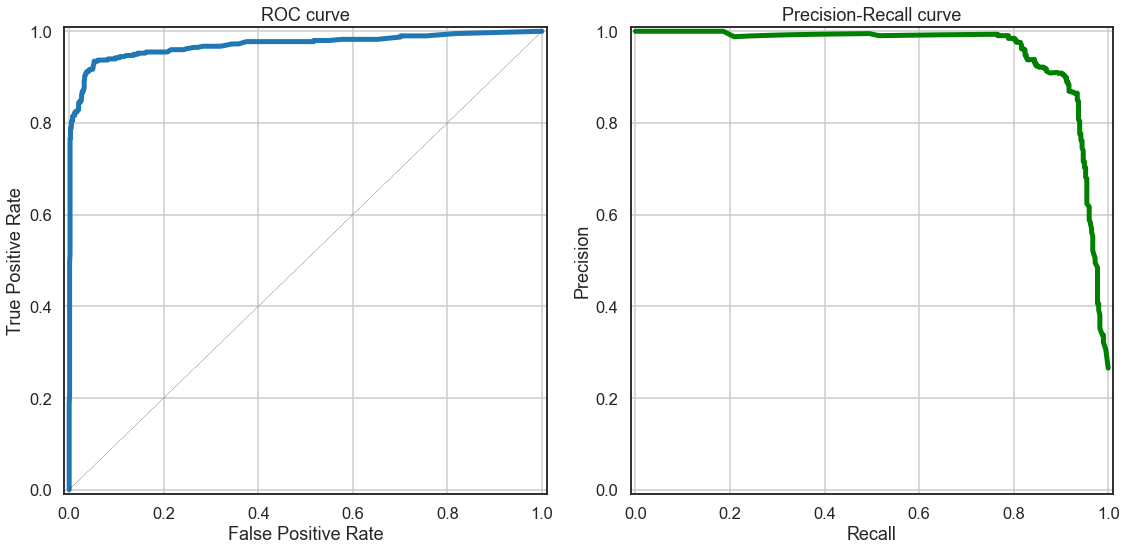

In [21]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, linewidth=5)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, color='green', linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

The feature importance plot shows customer satisfaction is the biggest predictor of churn.

[Text(0, 0.5, 'Feature')]

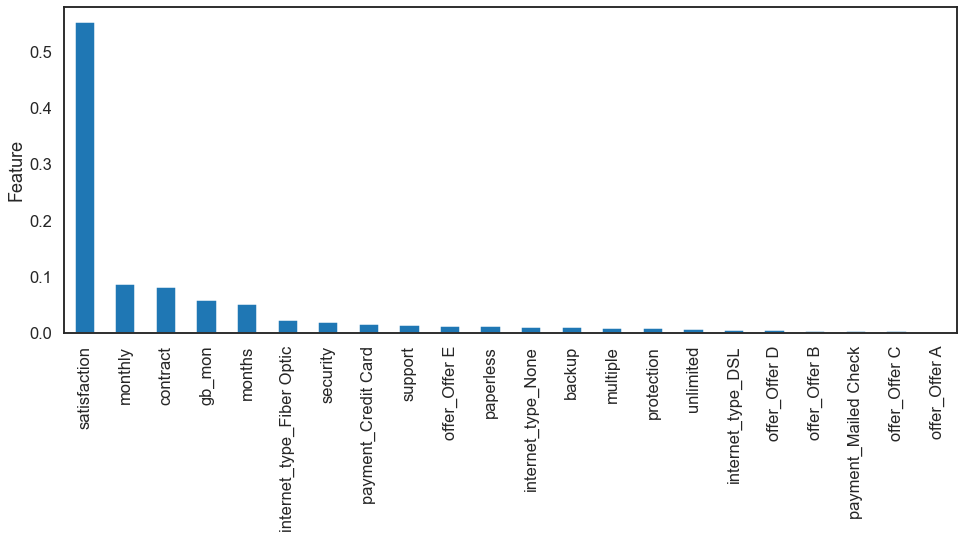

In [22]:
feature_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar', figsize=(16, 6))
ax.set(ylabel='Relative Importance')
ax.set(ylabel='Feature')

---
### Machine Learning Foundation (C) 2020 IBM Corporation